<a href="https://colab.research.google.com/github/MZiaAfzal71/Average_Weighted_Path_Vector/blob/main/Data%20Files/Data%20Statistics/Base_Line_Statistical_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MZiaAfzal71/Average_Weighted_Path_Vector.git
%cd Average_Weighted_Path_Vector/Data\ Files

Cloning into 'Average_Weighted_Path_Vector'...
remote: Enumerating objects: 713, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 713 (delta 83), reused 8 (delta 8), pack-reused 585 (from 1)
Receiving objects: 100% (713/713), 30.62 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (237/237), done.
/content/Average_Weighted_Path_Vector/Data Files


In [2]:
!pip install osfclient
import shutil
from osfclient.api import OSF
from subprocess import run
import os

# Replace with your OSF project ID
project_id = "p5ga2"   # e.g. from https://osf.io/abcd3/
osf = OSF()
project = osf.project(project_id)
store = project.storage("osfstorage")

desc_folder = []
for fold in store.folders:
    if fold.path.strip("/") != "Descriptors Data":
        desc_folder.append(fold)


# Download all files and keep folder structure
for folder in desc_folder:
  for f in folder.files:
      local_path = f.path.strip("/")            # keep folders
      local_dir = os.path.dirname(local_path)   # extract dir
      if local_dir and not os.path.exists(local_dir):
          os.makedirs(local_dir, exist_ok=True) # create dirs if missing
      with open(local_path, "wb") as out:
          f.write_to(out)
      if local_path.endswith(".zip"):
        command = f"unzip '{local_path}' -d '{local_dir}'"
        run(command, shell=True)
        print(f"\nUnzipped {local_path} -> {local_dir}")
        try:
          shutil.rmtree(os.path.join(local_dir, "__MACOSX"))
          print("Directory deleted successfully.")
        except OSError as e:
          print(f"Error: {e}")
      print(f"Downloaded {f.path} -> {local_path}")

100%|██████████| 3.55M/3.55M [00:00<00:00, 42.1Mbytes/s]



Unzipped desc_only_output/ANNDescriptorsOnly.zip -> desc_only_output
Directory deleted successfully.
Downloaded /desc_only_output/ANNDescriptorsOnly.zip -> desc_only_output/ANNDescriptorsOnly.zip


100%|██████████| 3.44M/3.44M [00:00<00:00, 26.2Mbytes/s]



Unzipped chemberta_model_output/ChemBERTaModel.zip -> chemberta_model_output
Directory deleted successfully.
Downloaded /chemberta_model_output/ChemBERTaModel.zip -> chemberta_model_output/ChemBERTaModel.zip


100%|██████████| 3.63M/3.63M [00:00<00:00, 39.4Mbytes/s]



Unzipped chemberta_film_fusion_output/ChemBERTaFiLMFusion.zip -> chemberta_film_fusion_output
Directory deleted successfully.
Downloaded /chemberta_film_fusion_output/ChemBERTaFiLMFusion.zip -> chemberta_film_fusion_output/ChemBERTaFiLMFusion.zip


100%|██████████| 10.3M/10.3M [00:00<00:00, 31.0Mbytes/s]



Unzipped XGBoost Results/xgboost_results.zip -> XGBoost Results
Directory deleted successfully.
Downloaded /XGBoost Results/xgboost_results.zip -> XGBoost Results/xgboost_results.zip


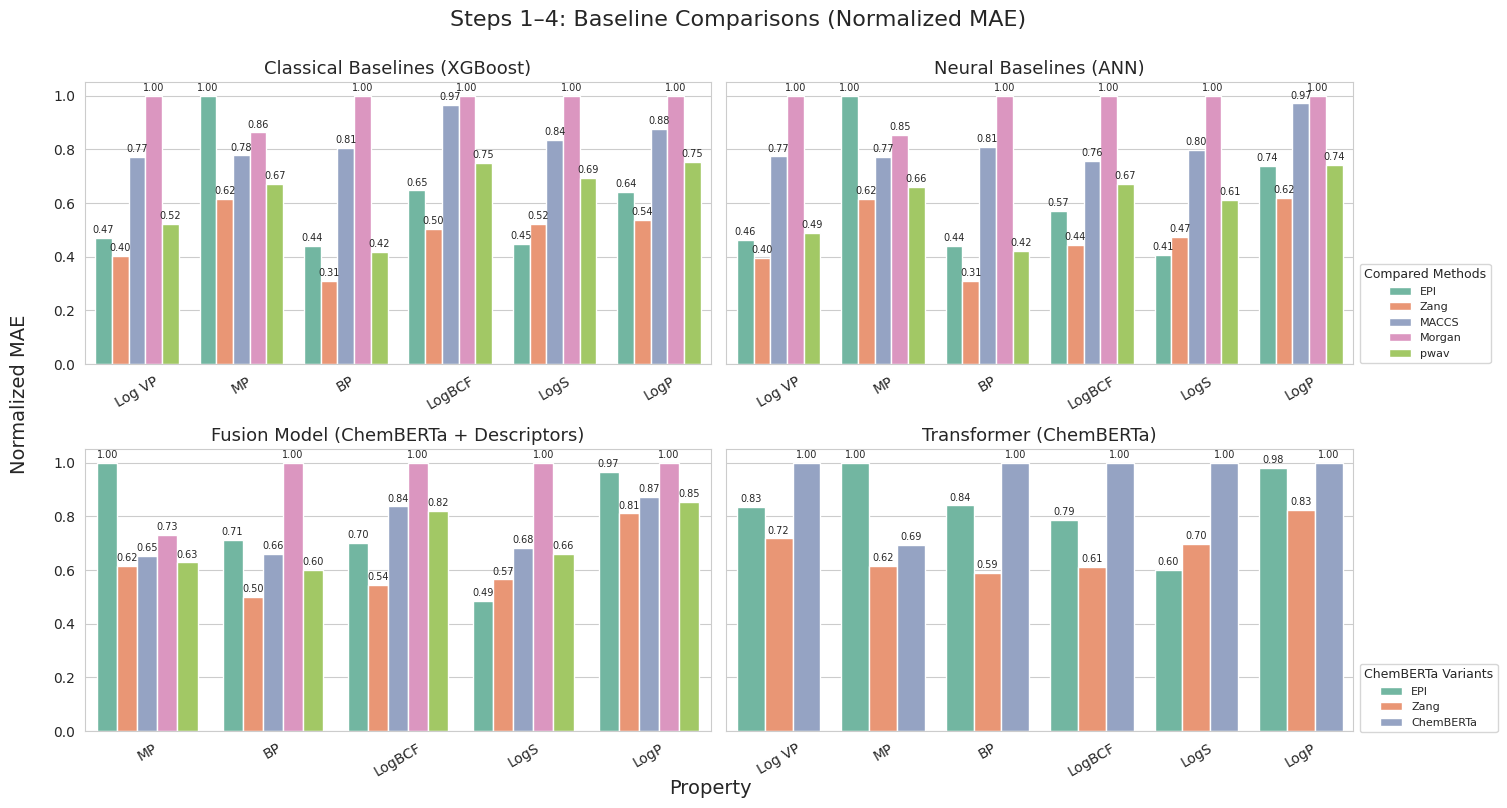

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")

# ----------------------------
# Config
# ----------------------------

main_df = pd.read_excel("Excel Files/Zang_Data.xlsx", sheet_name=None)

properties = ["Log VP", "MP", "BP", "LogBCF", "LogS", "LogP"]
descriptors = ["MACCS", "Morgan", "pwav"]
order = ["EPI", "Zang", "MACCS", "Morgan", "pwav", "ChemBERTa"]

# file_save_path = os.path.join(folder, "figures")
# os.makedirs(file_save_path, exist_ok=True)

# ----------------------------
# Helper to load & compute MAE
# ----------------------------
def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def collect_results(folder, suffix, mode="xgboost"):
    folder = Path(folder)
    results = []
    for prop in properties:
        main_df_prop = main_df[prop]
        if mode == "chemberta":
            file = folder / f"{prop}_chemBERTa_preds.xlsx"
            if not file.exists():
                continue
            df = pd.read_excel(file)

            y_true = df.iloc[:, 5].values
            epi = df.iloc[:, 6].values
            zang = df.iloc[:, 7].values
            y_pred = df.iloc[:, 9].values
            split = df.iloc[:, 8].values

            for split_name in ["Training", "Test"]:
                mask = split == split_name
                results.append((prop, split_name, "EPI", compute_mae(y_true[mask], epi[mask])))
                results.append((prop, split_name, "Zang", compute_mae(y_true[mask], zang[mask])))
                results.append((prop, split_name, "ChemBERTa", compute_mae(y_true[mask], y_pred[mask])))

        elif mode == "ann":
            for desc in descriptors:
                file = folder / f"{prop}_{desc}.parquet"
                if not file.exists():
                    continue

                df = pd.read_parquet(file)

                y_true = main_df_prop.iloc[:, 5].values
                epi = main_df_prop.iloc[:, 6].values
                zang = main_df_prop.iloc[:, 7].values
                y_pred = df.iloc[:, -2].values
                split = main_df_prop.iloc[:, 8].values

                for split_name in ["Training", "Test"]:
                    mask = split == split_name
                    results.append((prop, split_name, "EPI", compute_mae(y_true[mask], epi[mask])))
                    results.append((prop, split_name, "Zang", compute_mae(y_true[mask], zang[mask])))
                    results.append((prop, split_name, desc, compute_mae(y_true[mask], y_pred[mask])))
        elif mode == "chemberta_film":
          for desc in descriptors:
                file = folder / f"chemberta_{prop}_{desc}.parquet"
                if not file.exists():
                    continue

                df = pd.read_parquet(file)

                y_true = main_df_prop.iloc[:, 5].values
                epi = main_df_prop.iloc[:, 6].values
                zang = main_df_prop.iloc[:, 7].values
                y_pred = df.iloc[:, -2].values
                split = main_df_prop.iloc[:, 8].values

                for split_name in ["Training", "Test"]:
                    mask = split == split_name
                    results.append((prop, split_name, "EPI", compute_mae(y_true[mask], epi[mask])))
                    results.append((prop, split_name, "Zang", compute_mae(y_true[mask], zang[mask])))
                    results.append((prop, split_name, desc, compute_mae(y_true[mask], y_pred[mask])))
        else:
          for desc in descriptors:
                file = folder / f"{prop}_{desc}_{suffix}"
                if not file.exists():
                    continue

                df = pd.read_excel(file)

                y_true = df.iloc[:, 5].values
                epi = df.iloc[:, 6].values
                zang = df.iloc[:, 7].values
                y_pred = df.iloc[:, 9].values
                split = df.iloc[:, 8].values

                for split_name in ["Training", "Test"]:
                    mask = split == split_name
                    results.append((prop, split_name, "EPI", compute_mae(y_true[mask], epi[mask])))
                    results.append((prop, split_name, "Zang", compute_mae(y_true[mask], zang[mask])))
                    results.append((prop, split_name, desc, compute_mae(y_true[mask], y_pred[mask])))

    df_res = pd.DataFrame(results, columns=["Property", "Split", "Method", "MAE"])
    df_res["Norm_MAE"] = df_res.groupby(["Property", "Split"])["MAE"].transform(lambda x: x / x.max())
    return df_res

# ----------------------------
# Collect all steps
# ----------------------------
step1 = collect_results("XGBoost Results", "xgboost.xlsx", mode="xgboost")
step2 = collect_results("desc_only_output", ".parquet", mode="ann")
step3 = collect_results("chemberta_model_output", None, mode="chemberta")
step4 = collect_results("chemberta_film_fusion_output", None, mode="chemberta_film")
# ----------------------------
# Plot all in one (side by side)
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

steps = [
    (step1, "Classical Baselines (XGBoost)", axes[0, 0]),
    (step2, "Neural Baselines (ANN)", axes[0, 1]),
    (step4, "Fusion Model (ChemBERTa + Descriptors)", axes[1, 0]),
    (step3, "Transformer (ChemBERTa)", axes[1, 1]),
]

# Plotting
for df_step, title, ax in steps:
    sns.barplot(
        data=df_step[df_step["Split"]=="Test"],
        x="Property", y="Norm_MAE", hue="Method",
        hue_order=[m for m in order if m in df_step["Method"].unique()],
        palette="Set2", ax=ax, errorbar=None
    )
    ax.set_title(title, fontsize=13)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()
    ax.tick_params(axis='x', labelrotation=30)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=7, padding=2)

# ----------------------------
# Legends
# ----------------------------
handles1, labels1 = axes[0, 0].get_legend_handles_labels()
handles2, labels2 = axes[1, 1].get_legend_handles_labels()

leg1 = fig.legend(handles1, labels1, title="Compared Methods",
                  bbox_to_anchor=(0.94, 0.67), loc="upper left", fontsize=8, title_fontsize=9)
leg2 = fig.legend(handles2, labels2, title="ChemBERTa Variants",
                  bbox_to_anchor=(0.94, 0.17), loc="upper left", fontsize=8, title_fontsize=9)

# ----------------------------
# Final layout
# ----------------------------
fig.text(0.48, 0.0, 'Property', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Normalized MAE', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Steps 1–4: Baseline Comparisons (Normalized MAE)", fontsize=16)
plt.tight_layout(rect=[0,0,0.95,0.98])
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/step1_3_combined_allprops_sidebyside.png", dpi=300)
plt.show()


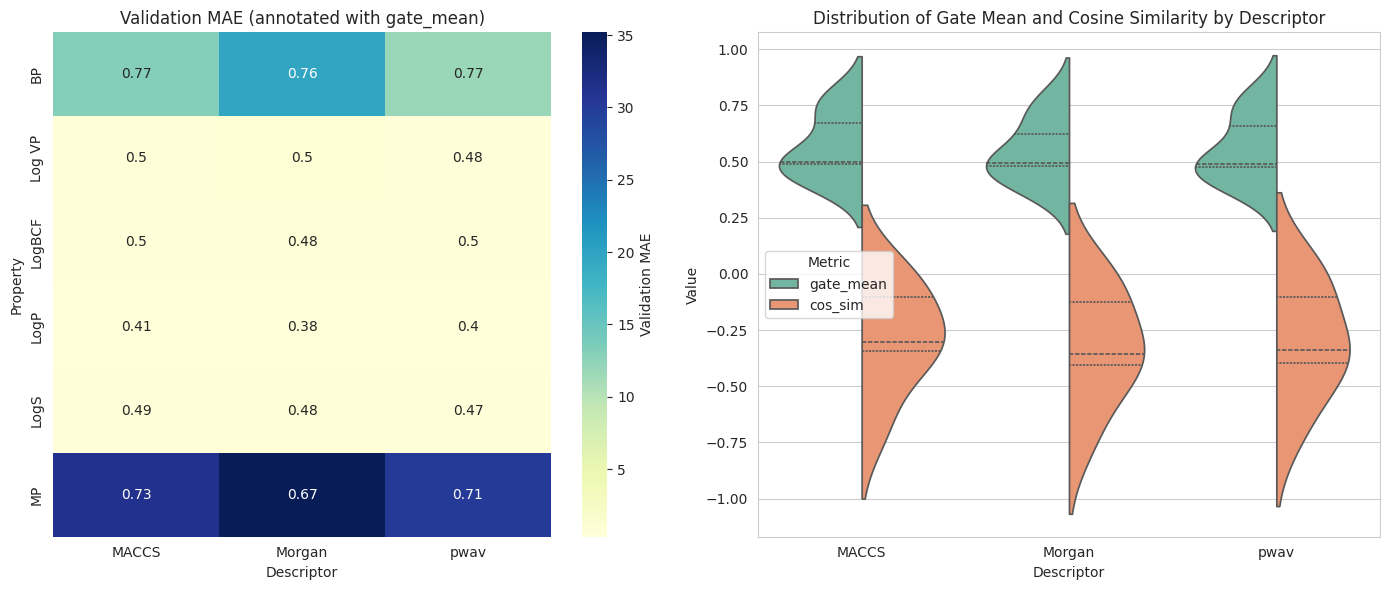

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Load all 18 logs (assuming naming convention like "PROPERTY_DESCRIPTOR_training_log.csv")
log_files = glob.glob("chemberta_film_fusion_output/*_training_log.csv")

dfs = []
for f in log_files:
    base = os.path.basename(f).replace("_training_log.csv","")
    try:
        prop, desc = base.split("_")
    except:
        # fallback if name has issues
        parts = base.split("_")
        prop, desc = parts[0], parts[1]
    df = pd.read_csv(f)
    df["Property"] = prop
    df["Descriptor"] = desc
    dfs.append(df)

all_logs = pd.concat(dfs, ignore_index=True)
all_logs.loc[all_logs['Descriptor'] == "Morgan", "Descriptor"] = "ECFP4"

# Aggregate final epoch stats
summary = (
    all_logs.sort_values("epoch")
    .groupby(["Property","Descriptor"])
    .tail(1)[["Property","Descriptor","val_mae","gate_mean","cos_sim"]]
)

# Heatmap data: pivot table of val_mae with annotations of gate_mean
heatmap_data = summary.pivot(index="Property", columns="Descriptor", values="val_mae")
annot_data = summary.pivot(index="Property", columns="Descriptor", values="gate_mean")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Left panel: heatmap with annotations
sns.heatmap(
    heatmap_data, annot=annot_data.round(2),
    fmt="", cmap="YlGnBu", cbar_kws={"label":"Validation MAE"}, ax=axes[0]
)
axes[0].set_title("Validation MAE (annotated with gate_mean)")

# Right panel: violin plots of gate_mean & cos_sim by descriptor
melted = summary.melt(id_vars=["Property","Descriptor"], value_vars=["gate_mean","cos_sim"],
                      var_name="Metric", value_name="Value")

sns.violinplot(
    data=melted, x="Descriptor", y="Value", hue="Metric",
    split=True, inner="quart", ax=axes[1], palette="Set2"
)
axes[1].set_title("Distribution of Gate Mean and Cosine Similarity by Descriptor")
axes[1].legend(title="Metric")

plt.tight_layout()
plt.show()
